# Bias-Variance Tradeoff

Demonstrating the fundamental tradeoff in machine learning:
1. Understanding bias and variance
2. Visualizing the tradeoff
3. Effect of model complexity
4. Effect of regularization

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)


---
## Generate True Function

We'll use a simple non-linear function and add noise.

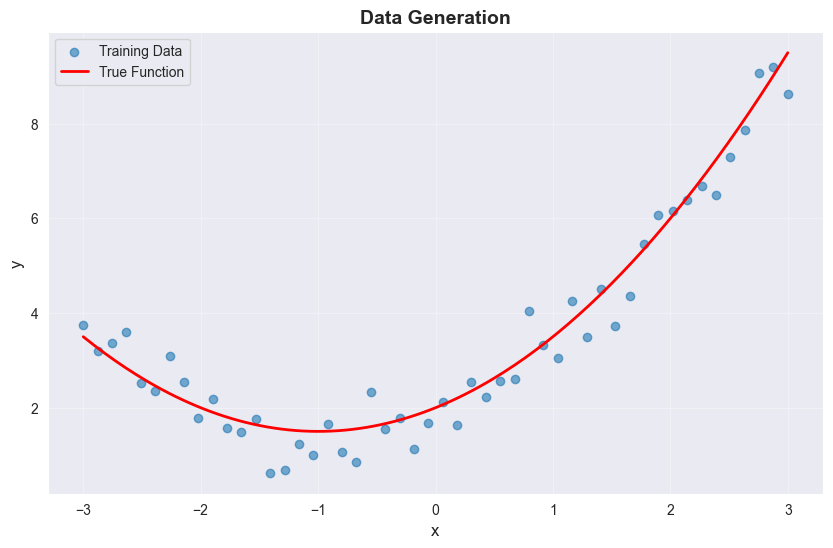

In [2]:
# True function: quadratic
def true_function(x):
    return 0.5 * x**2 + x + 2

# Generate data
n_samples = 50
X = np.linspace(-3, 3, n_samples)
y_true = true_function(X)
y_noisy = y_true + np.random.randn(n_samples) * 0.5

# Test points for visualization
X_test = np.linspace(-3, 3, 200)
y_test_true = true_function(X_test)

plt.figure(figsize=(10, 6))
plt.scatter(X, y_noisy, alpha=0.6, label='Training Data')
plt.plot(X_test, y_test_true, 'r-', linewidth=2, label='True Function')
plt.xlabel('x', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('Data Generation', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


---
## Experiment 1: Model Complexity

Compare polynomial models of different degrees.

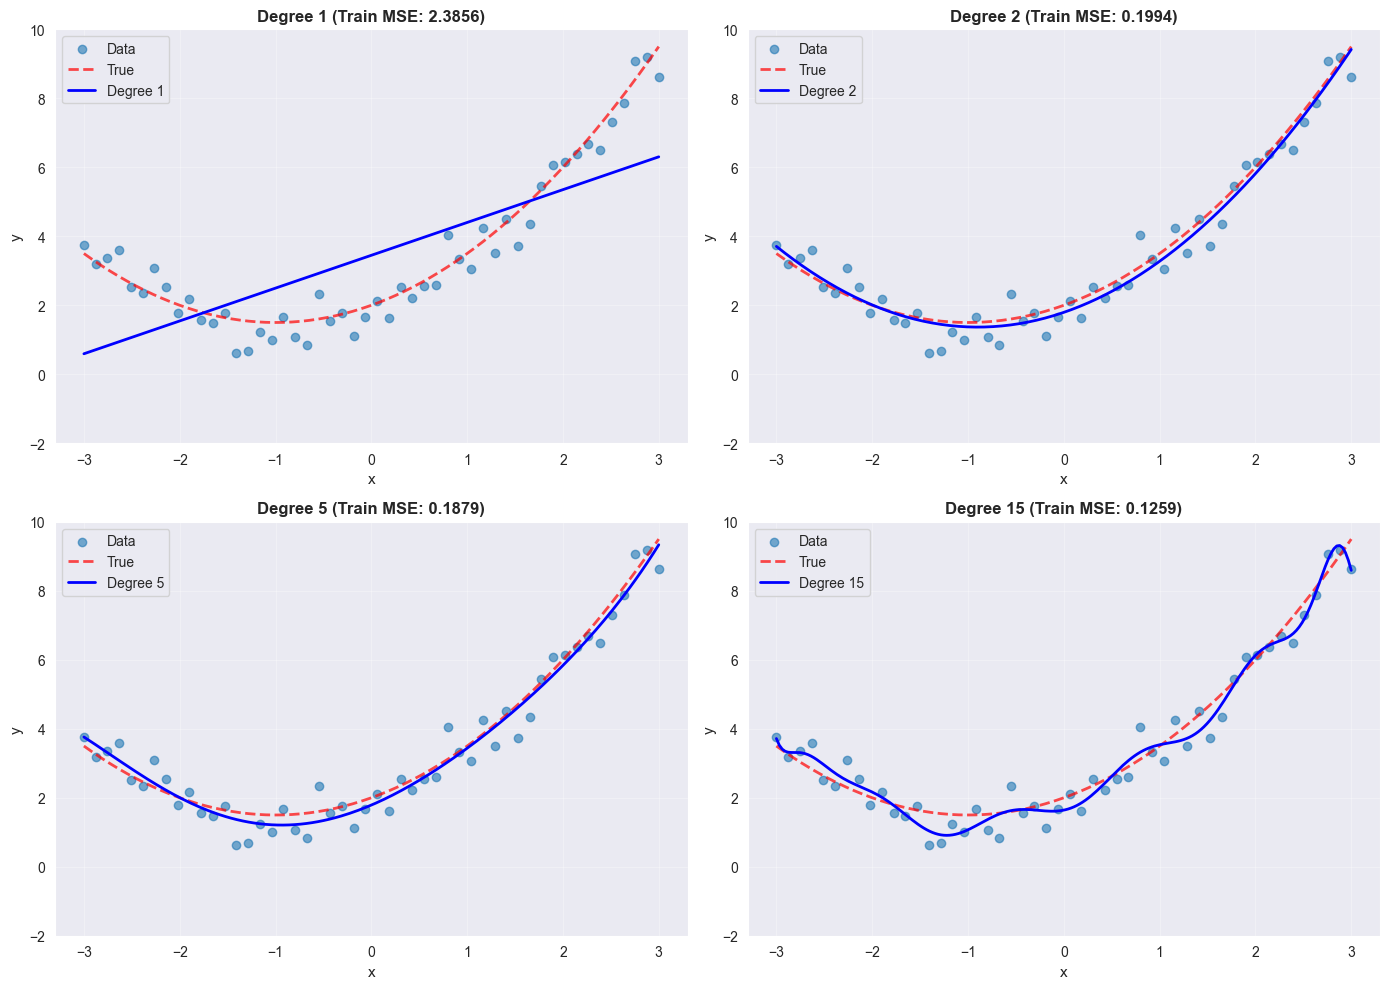

In [3]:
degrees = [1, 2, 5, 15]
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()

for idx, degree in enumerate(degrees):
    # Fit polynomial
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    X_test_poly = poly.transform(X_test.reshape(-1, 1))
    
    # Train
    theta = np.linalg.lstsq(X_poly, y_noisy, rcond=None)[0]
    y_pred = X_test_poly.dot(theta)
    
    # Calculate train MSE
    train_pred = X_poly.dot(theta)
    train_mse = np.mean((train_pred - y_noisy)**2)
    
    # Plot
    axes[idx].scatter(X, y_noisy, alpha=0.6, label='Data')
    axes[idx].plot(X_test, y_test_true, 'r--', linewidth=2, label='True', alpha=0.7)
    axes[idx].plot(X_test, y_pred, 'b-', linewidth=2, label=f'Degree {degree}')
    axes[idx].set_xlabel('x', fontsize=11)
    axes[idx].set_ylabel('y', fontsize=11)
    axes[idx].set_title(f'Degree {degree} (Train MSE: {train_mse:.4f})', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-2, 10)

plt.tight_layout()
plt.show()


### Observations:
- **Degree 1**: High bias - underfits (too simple)
- **Degree 2**: Just right - captures true pattern
- **Degree 5**: Starting to overfit
- **Degree 15**: High variance - overfits (wiggly, follows noise)

---
## Experiment 2: Bias-Variance with Multiple Datasets

Generate multiple datasets to see variance.

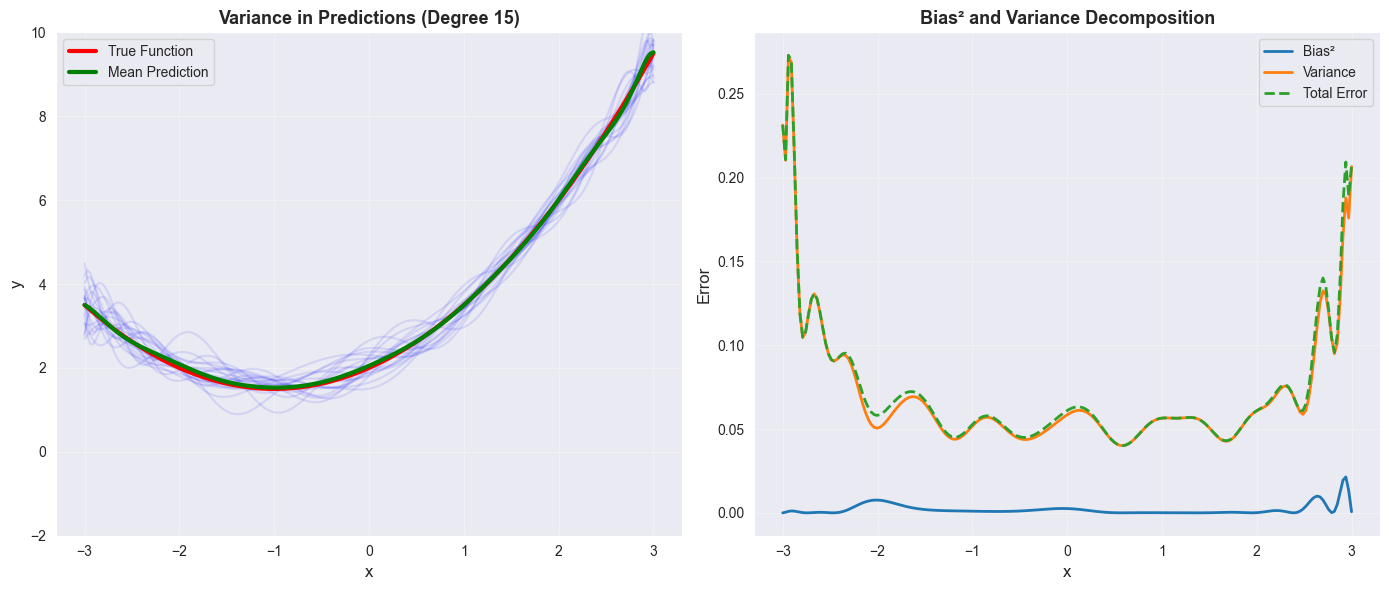

Mean Bias²: 0.0019
Mean Variance: 0.0705
Total Error: 0.0725


In [4]:
n_datasets = 50
degree_to_test = 15

# Store predictions for each dataset
all_predictions = []

for i in range(n_datasets):
    # Generate new noisy data
    y_i = y_true + np.random.randn(n_samples) *0.5
    
    # Fit model
    poly = PolynomialFeatures(degree=degree_to_test)
    X_poly = poly.fit_transform(X.reshape(-1, 1))
    X_test_poly = poly.transform(X_test.reshape(-1, 1))
    
    theta = np.linalg.lstsq(X_poly, y_i, rcond=None)[0]
    y_pred = X_test_poly.dot(theta)
    all_predictions.append(y_pred)

all_predictions = np.array(all_predictions)

# Compute bias and variance
mean_prediction = np.mean(all_predictions, axis=0)
bias_squared = (mean_prediction - y_test_true)**2
variance = np.var(all_predictions, axis=0)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left: All predictions
for pred in all_predictions[:20]:  # Show first 20
    axes[0].plot(X_test, pred, 'b-', alpha=0.1)
axes[0].plot(X_test, y_test_true, 'r-', linewidth=3, label='True Function')
axes[0].plot(X_test, mean_prediction, 'g-', linewidth=3, label='Mean Prediction')
axes[0].set_xlabel('x', fontsize=12)
axes[0].set_ylabel('y', fontsize=12)
axes[0].set_title(f'Variance in Predictions (Degree {degree_to_test})', fontsize=13, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_ylim(-2, 10)

# Right: Bias and Variance
axes[1].plot(X_test, bias_squared, linewidth=2, label='Bias²')
axes[1].plot(X_test, variance, linewidth=2, label='Variance')
axes[1].plot(X_test, bias_squared + variance, linewidth=2, label='Total Error', linestyle='--')
axes[1].set_xlabel('x', fontsize=12)
axes[1].set_ylabel('Error', fontsize=12)
axes[1].set_title('Bias² and Variance Decomposition', fontsize=13, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'Mean Bias²: {np.mean(bias_squared):.4f}')
print(f'Mean Variance: {np.mean(variance):.4f}')
print(f'Total Error: {np.mean(bias_squared + variance):.4f}')


---
## Experiment 3: Bias-Variance vs Model Complexity

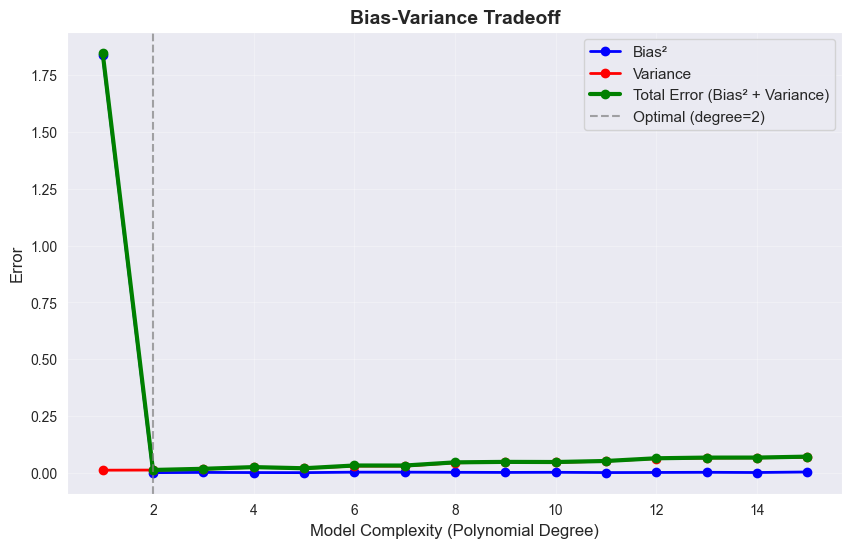

In [5]:
degrees_range = range(1, 16)
bias_list = []
variance_list = []
total_error_list = []

for degree in degrees_range:
    predictions = []
    
    for i in range(30):  # 30 datasets
        y_i = y_true + np.random.randn(n_samples) * 0.5
        
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        X_test_poly = poly.transform(X_test.reshape(-1, 1))
        
        theta = np.linalg.lstsq(X_poly, y_i, rcond=None)[0]
        y_pred = X_test_poly.dot(theta)
        predictions.append(y_pred)
    
    predictions = np.array(predictions)
    mean_pred = np.mean(predictions, axis=0)
    
    bias_sq = np.mean((mean_pred - y_test_true)**2)
    var = np.mean(np.var(predictions, axis=0))
    
    bias_list.append(bias_sq)
    variance_list.append(var)
    total_error_list.append(bias_sq + var)

# Plot the tradeoff
plt.figure(figsize=(10, 6))
plt.plot(degrees_range, bias_list, 'b-o', linewidth=2, label='Bias²', markersize=6)
plt.plot(degrees_range, variance_list, 'r-o', linewidth=2, label='Variance', markersize=6)
plt.plot(degrees_range, total_error_list, 'g-o', linewidth=3, label='Total Error (Bias² + Variance)', markersize=6)

# Mark optimal
optimal_idx = np.argmin(total_error_list)
plt.axvline(x=list(degrees_range)[optimal_idx], color='gray', linestyle='--', alpha=0.7, label=f'Optimal (degree={list(degrees_range)[optimal_idx]})')

plt.xlabel('Model Complexity (Polynomial Degree)', fontsize=12)
plt.ylabel('Error', fontsize=12)
plt.title('Bias-Variance Tradeoff', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()


### Key Observations:

1. **Low complexity** (degree 1-2): High bias, low variance
   - Model is too simple
   - Consistent but inaccurate predictions
   
2. **Optimal complexity** (degree ~2-3): Balanced
   - Lowest total error
   - Sweet spot!
   
3. **High complexity** (degree > 10): Low bias, high variance
   - Model is too complex
   - Fits noise, predictions vary wildly

---
## Experiment 4: Effect of Regularization

C:\Users\Sreekar\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.03894e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\Sreekar\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.03894e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\Sreekar\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.03894e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\Sreekar\AppData\Local\Programs\Python\Python314\Lib\site-packages\scipy\_lib\_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=2.03894e-17): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)
C:\Users\Sreekar\AppData\Local\Programs\Python\Python314\Lib\site-packages\s

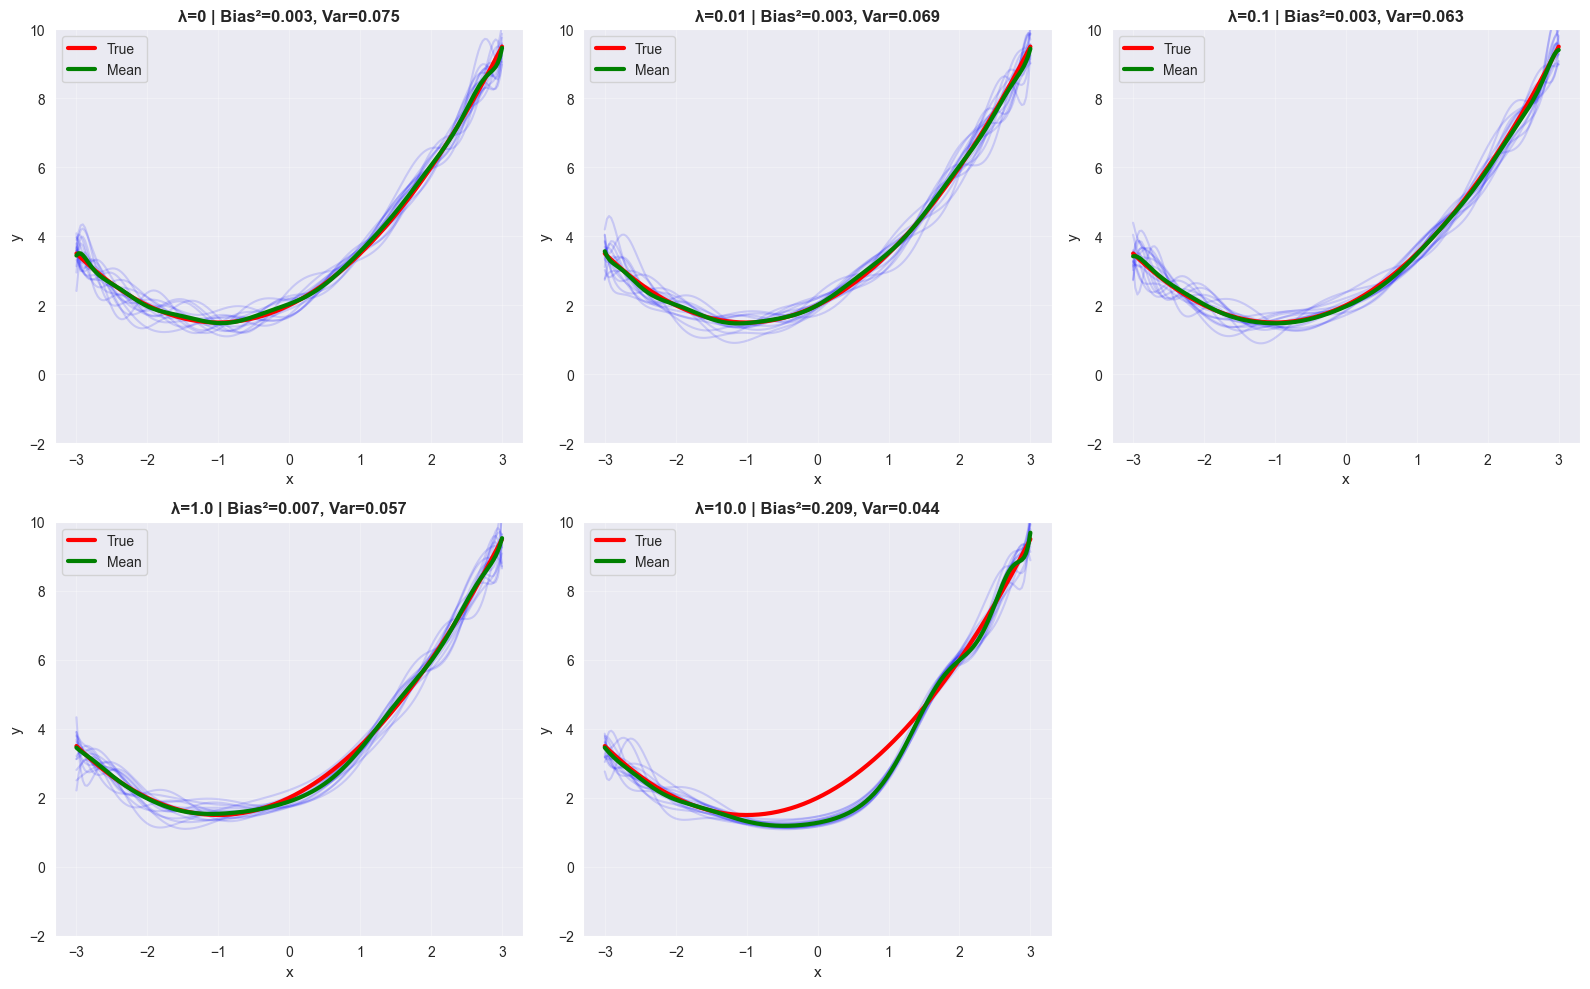

In [6]:
# High degree polynomial with different regularization
degree = 15
lambdas = [0, 0.01, 0.1, 1.0, 10.0]

fig, axes = plt.subplots(2, 3, figsize=(16, 10))
axes = axes.ravel()

for idx, lam in enumerate(lambdas):
    predictions = []
    
    for i in range(30):
        y_i = y_true + np.random.randn(n_samples) * 0.5
        
        poly = PolynomialFeatures(degree=degree)
        X_poly = poly.fit_transform(X.reshape(-1, 1))
        X_test_poly = poly.transform(X_test.reshape(-1, 1))
        
        # Ridge regression
        model = Ridge(alpha=lam, fit_intercept=False)
        model.fit(X_poly, y_i)
        y_pred = model.predict(X_test_poly)
        predictions.append(y_pred)
    
    predictions = np.array(predictions)
    mean_pred = np.mean(predictions, axis=0)
    
    bias_sq = np.mean((mean_pred - y_test_true)**2)
    var = np.mean(np.var(predictions, axis=0))
    
    # Plot
    for pred in predictions[:15]:
        axes[idx].plot(X_test, pred, 'b-', alpha=0.15)
    axes[idx].plot(X_test, y_test_true, 'r-', linewidth=3, label='True')
    axes[idx].plot(X_test, mean_pred, 'g-', linewidth=3, label='Mean')
    axes[idx].set_xlabel('x', fontsize=11)
    axes[idx].set_ylabel('y', fontsize=11)
    axes[idx].set_title(f'λ={lam} | Bias²={bias_sq:.3f}, Var={var:.3f}', fontsize=12, fontweight='bold')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_ylim(-2, 10)

# Hide extra subplot
axes[5].axis('off')

plt.tight_layout()
plt.show()


### Regularization Effect:

- **λ = 0**: High variance (overfits)
- **λ = 0.01-0.1**: Reduced variance
- **λ = 1.0**: Balanced
- **λ = 10.0**: Increased bias (underfits)

**Regularization trades variance for bias!**

---
## Summary

### Bias:
- Error from wrong assumptions
- High bias → underfitting
- Model too simple

### Variance:
- Error from sensitivity to training data
- High variance → overfitting  
- Model too complex

### Total Error:
$$\text{Total Error} = \text{Bias}^2 + \text{Variance} + \text{Irreducible Error}$$

### Managing the Tradeoff:
1. **Increase model complexity** → ↓ bias, ↑ variance
2. **Decrease model complexity** → ↑ bias, ↓ variance
3. **Add regularization** → ↑ bias, ↓ variance
4. **More training data** → ↓ variance (doesn't change bias much)
5. **Feature engineering** → Can reduce both

### In Practice:
- Use **cross-validation** to find optimal complexity
- Monitor train vs validation error
- Start simple, add complexity if needed
- Regularize complex models

**Interview Tip**: "The bias-variance tradeoff is fundamental: simple models have high bias but low variance; complex models have low bias but high variance. I'd use cross-validation to find the sweet spot that minimizes total error."